In [30]:
#Chargement des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.pylab as pylab
os.chdir('/home/allan/Documents/PONANT/Data')

In [31]:
#Lecture de la table PBSSCALENDAR
df_PB = pd.read_excel('PBSSCALENDAR.xlsx')
#Les variables clairement inutiles à la problèmatique sont à supprimer
df_PB.drop([ 'ID', 
             'UID', 
             'Editor', 
             'Creation_Timestamp', 
             'Edition_Timestamp'] , axis = 1 ,inplace = True)
#On retient uniquement les croisière ayant une date de départ2015 ou plus tard 
df_PB = df_PB[ df_PB['Cruise_Code'].str[-2:].astype(int) >14]
#Supprimer les lignes sans date d'application du PB (Pré-enregistrement?)
df_PB_by_cruise = df_PB[~df_PB['PBSS_CAL_Date'].isna()]
#Tri de la table par croisière et par date
df_PB.sort_values([ 'Cruise_Code' ,'PBSS_CAL_Date'] , inplace = True)
#Vérifier le type des variables
df_PB.dtypes

Cruise_Code              object
PBSS_CAL_Date    datetime64[ns]
PB_CAL_Amount           float64
SS_CAL_Amount           float64
PBSS_LT_Week            float64
ND_CAL_Amount           float64
dtype: object

In [32]:
#Vérifier que les dates sont les bonnes formant une série temporelle par croisière, entre l'ouverture des ventes et la date de la croisière
#Dour chaque croisière: Nombre de dates uniques == nombre de lignes == nombre de jours entre la première date et la dernière
df_PB_by_cruise = df_PB_by_cruise.groupby('Cruise_Code').agg({
        'PBSS_CAL_Date' : ['nunique', 'count', 'min', 'max' ],})
df_PB_by_cruise.reset_index(inplace =True)
df_PB_by_cruise['NB_days'] = (df_PB_by_cruise.PBSS_CAL_Date['max'] - df_PB_by_cruise.PBSS_CAL_Date['min']).dt.days + 1 
df_PB_by_cruise[df_PB_by_cruise.PBSS_CAL_Date['count'] != df_PB_by_cruise.PBSS_CAL_Date['nunique'] ]
df_PB_by_cruise[df_PB_by_cruise.PBSS_CAL_Date['count'] != df_PB_by_cruise['NB_days'] ]

Cruise_Code PBSS_CAL_Date                             NB_days
                    nunique count        min        max        
6     A011215           730   730 2013-12-03 2016-10-25    1058

In [33]:
#Correction des erreurs
index_to_remove = df_PB[(df_PB.Cruise_Code == 'A011215') & (df_PB.PBSS_CAL_Date == '2016-10-25')].index.values
df_PB.drop(index_to_remove , axis = 0, inplace = True)
df_PB.loc[(df_PB['Cruise_Code'] == 'P030513') & (df_PB['PBSS_CAL_Date'].dt.year <2016) ,'Cruise_Code' ] = 'P030513_1'
df_PB.loc[(df_PB['Cruise_Code'] == 'P030513') & (df_PB['PBSS_CAL_Date'].dt.year >= 2016) ,'Cruise_Code' ] = 'P030513_2'

In [57]:
#Chargement de l'extrait de données, 
df = pd.read_excel('Data_First_Extract.xlsx')
#selection de croisières partant après 2014
df = df[ df['Key_Cruise_Code'].str[-2:].astype(int) >14]
#suppression des variables statiques, et des ratios mal calculés
variables_to_remove = ['Mapping_Charter',
                       'Mapping_Cruise_Status',
                       'Mapping_Cluster_ML',
                       'Mapping_Histo_ML',
                       'Mapping_Destination_Production',
                       'Occupation_Rate_excl_OPT',
                       'Part_de_Pax_Paying_FBS'
                       ]
df.drop(variables_to_remove , axis = 1, inplace = True)
#Repérer les Valeurs manquantes dans les photos
df = df.fillna(value = 9999999999)
df.dtypes

Key_Booking_Date_OBS                        object
Mapping_Vessel                              object
Mapping_LOS                                  int64
Mapping_Date_Departure              datetime64[ns]
Mapping_Year_Departure                       int64
Mapping_From_To                             object
Mapping_Destination                         object
Mapping_Season                              object
Mapping_Theme                               object
Mapping_Guest                               object
Mapping_Partnership                         object
Mapping_Cluster_Pricing                     object
Mapping_FCST_Model                          object
Mapping_Destination_Semester                object
Mapping_Cluster_Pricing_2                   object
Mapping_Cabin_Capacity                       int64
Mapping_Lead_Time_Days                       int64
Key_Cruise_Code                             object
Total_Pax_Paying                           float64
Total_Cab_Paying               

In [58]:
#Correction du format de la variable Key_Booking_Date_OBS 
df['Key_Booking_Date_OBS'] = pd.to_datetime(df['Key_Booking_Date_OBS'])
#Jointure des deux tables
df = pd.merge(left = df_PB,
              right = df,
              left_on = ['Cruise_Code' ,  'PBSS_CAL_Date'],
              right_on = ['Key_Cruise_Code' , 'Key_Booking_Date_OBS'] ,
              how = 'left')

In [59]:
#sélection des colonnes à remplir (variables en provenance des photos hebdomadaires)
columns_to_fill = [col for col in list(df.columns) if (col not in list(df_PB.columns))]
#Repérer la dernière ligne de chaque croisière (soit des barières empéchant la copie de données entre différentes croisières )
df['index'] = df.index
last_line_by_cruise = list(df[['Cruise_Code', 'index']].groupby('Cruise_Code').last()['index'])
df.loc[df.index.isin(last_line_by_cruise) & df['Key_Booking_Date_OBS'].isna() , columns_to_fill] = 1111111111
#Copie de la prochaine photo valide par croisière
df[columns_to_fill] = df[columns_to_fill].fillna(method = 'bfill')
#Remise des "vrais valeurs manquantes"
df = df.replace({9999999999 : np.nan})
#Suppression des dernières lignes de croisière sans photo
df = df[~ (df['Key_Booking_Date_OBS'] == 1111111111)] 
df.drop(['index', 'Key_Booking_Date_OBS' , 'Key_Cruise_Code'], axis = 1, inplace = True)  

In [60]:
#Nombre de Valeurs manquantes par colonnes
df.isnull().sum()

Cruise_Code                              0
PBSS_CAL_Date                            0
PB_CAL_Amount                            0
SS_CAL_Amount                            0
PBSS_LT_Week                             0
ND_CAL_Amount                            0
Mapping_Vessel                           0
Mapping_LOS                              0
Mapping_Date_Departure                   0
Mapping_Year_Departure                   0
Mapping_From_To                          0
Mapping_Destination                      0
Mapping_Season                           0
Mapping_Theme                       344170
Mapping_Guest                       350399
Mapping_Partnership                 371335
Mapping_Cluster_Pricing                  0
Mapping_FCST_Model                     682
Mapping_Destination_Semester             0
Mapping_Cluster_Pricing_2                0
Mapping_Cabin_Capacity                   0
Mapping_Lead_Time_Days                   0
Total_Pax_Paying                         0
Total_Cab_P

In [39]:
#Types de variables
df.dtypes

Cruise_Code                                 object
PBSS_CAL_Date                       datetime64[ns]
PB_CAL_Amount                              float64
SS_CAL_Amount                              float64
PBSS_LT_Week                               float64
ND_CAL_Amount                              float64
Mapping_Vessel                              object
Mapping_LOS                                float64
Mapping_Date_Departure                      object
Mapping_Year_Departure                     float64
Mapping_From_To                             object
Mapping_Destination                         object
Mapping_Season                              object
Mapping_Theme                               object
Mapping_Guest                               object
Mapping_Partnership                         object
Mapping_Cluster_Pricing                     object
Mapping_FCST_Model                          object
Mapping_Destination_Semester                object
Mapping_Cluster_Pricing_2      

In [61]:
#Remplissage des valeurs manquantes pour les variables catégorielles
df.loc[df['Mapping_FCST_Model'].isna() , 'Mapping_FCST_Model'] = 'Unknown'
df.loc[df['Mapping_Theme'].isna() , 'Mapping_Theme'] = 'Other'
df.loc[df['Mapping_Guest'].isna() , 'Mapping_Guest'] = 'Other'
df.loc[df['Mapping_Partnership'].isna() , 'Mapping_Partnership'] = 'Other'

In [42]:
#Définition du format des variables catégorielles, et des variables datetime
categorical_variables = ['Mapping_Vessel',
                         'Mapping_From_To',
                         'Mapping_Destination',
                         'Mapping_Season',
                         'Mapping_Theme',
                         'Mapping_Guest',
                         'Mapping_Partnership',
                         'Mapping_Cluster_Pricing',
                         'Mapping_FCST_Model',
                         'Mapping_Destination_Semester',
                         'Mapping_Cluster_Pricing_2',
                        ]
df[categorical_variables] = df[categorical_variables].astype('category')
df['Date_Premiere_Reservation_Indiv'] = pd.to_datetime(df['Date_Premiere_Reservation_Indiv'])
df['Mapping_Date_Departure'] = pd.to_datetime(df['Mapping_Date_Departure'])
df.dtypes

Cruise_Code                                 object
PBSS_CAL_Date                       datetime64[ns]
PB_CAL_Amount                              float64
SS_CAL_Amount                              float64
PBSS_LT_Week                               float64
ND_CAL_Amount                              float64
Mapping_Vessel                            category
Mapping_LOS                                float64
Mapping_Date_Departure              datetime64[ns]
Mapping_Year_Departure                     float64
Mapping_From_To                           category
Mapping_Destination                       category
Mapping_Season                            category
Mapping_Theme                             category
Mapping_Guest                             category
Mapping_Partnership                       category
Mapping_Cluster_Pricing                   category
Mapping_FCST_Model                        category
Mapping_Destination_Semester              category
Mapping_Cluster_Pricing_2      

In [62]:
#Recalcul de la moyenne des Moyennes
cab_by_pb_var = ['Total_Cab_PB_30' , 'Total_Cab_PB_25', 'Total_Cab_PB_20',
     'Total_Cab_PB_15', 'Total_Cab_PB_10' , 'Total_Cab_PB_5', 'Total_Cab_PB_0']
df[cab_by_pb_var] = df[cab_by_pb_var].fillna(0)
df['Moyenne_PB'] = (0.30*df['Total_Cab_PB_30'] 
                    + 0.25*df['Total_Cab_PB_25']
                    + 0.20*df['Total_Cab_PB_20']
                    +0.15*df['Total_Cab_PB_15']
                    +0.10*df['Total_Cab_PB_10']
                    +0.05*df['Total_Cab_PB_5'])/(-df[cab_by_pb_var].sum(axis = 1))
df['Moyenne_PB'] = df['Moyenne_PB'].fillna(0)

df['Moyenne_PerDiem_Pax_EUR'] =  df['Total_NTR_EUR'] / df['Total_PCD_Paying']
df['Moyenne_PerDiem_Cabine_EUR'] =  df['Total_NTR_EUR'] / df['Total_CCD_Paying']

df['Moyenne Perdiem_Cabine EUR_Indiv'] = df['Total_NTR_EUR_INDIV'] / df['Total_CCD_Paying']
df['Moyenne Perdiem_Cabine EUR_Group'] = df['Total_NTR_EUR_Group'] /df['Total_CCD_Paying_Group']
df['Moyenne_Panier_EUR_Indiv'] = df['Total_NTR_EUR_INDIV'] /  df['Total_Cabin_Paying_Indiv']

In [63]:
#Remplacer les valeurs manquantes en 0 pour certaines valeurs manquantes
nan_to_zeros_var = ['Moyenne_PerDiem_Cabine_EUR',
                    'Moyenne_PerDiem_Pax_EUR',
                    'Moyenne Perdiem_Cabine EUR_Indiv',
                    'Moyenne Perdiem_Cabine EUR_Group',
                    'Moyenne_Panier_EUR_Indiv',
                    'Total_Cabin_GIP_Group',
                    ]
df[nan_to_zeros_var] = df[nan_to_zeros_var].fillna(0)

In [64]:
df.loc[ df['Cruise_Code'] == 'B190417' , ['PBSS_CAL_Date',  'Date_Premiere_Reservation_Indiv'] ]

PBSS_CAL_Date Date_Premiere_Reservation_Indiv
189049    2016-10-25         2015-06-29 00:00:00.000
189050    2016-10-26         2015-06-29 00:00:00.000
189051    2016-10-27         2015-06-29 00:00:00.000
189052    2016-10-28         2015-06-29 00:00:00.000
189053    2016-10-29         2015-06-29 00:00:00.000
189054    2016-10-30         2015-06-29 00:00:00.000
189055    2016-10-31         2015-06-29 00:00:00.000
189056    2016-11-01         2015-06-29 00:00:00.000
189057    2016-11-02         2015-06-29 00:00:00.000
189058    2016-11-03         2015-06-29 00:00:00.000
189059    2016-11-04         2015-06-29 00:00:00.000
189060    2016-11-05         2015-06-29 00:00:00.000
189061    2016-11-06         2015-06-29 00:00:00.000
189062    2016-11-07         2015-06-29 00:00:00.000
189063    2016-11-08         2015-06-29 00:00:00.000
189064    2016-11-09         2015-06-29 00:00:00.000
189065    2016-11-10         2015-06-29 00:00:00.000
189066    2016-11-11         2015-06-29 00:00:00.000
189067    2016-11-12         2015-06-29 00:00:00.000
189068    2016-11-13         2015-06-29 00:00:00.000
189069    2016-11-14         2015-06-29 00:00:00.000
189070    2016-11-15         2015-06-29 00:00:00.000
189071    2016-11-16         2015-06-29 00:00:00.000
189072    2016-11-17         2015-06-29 00:00:00.000
189073    2016-11-18         2015-06-29 00:00:00.000
189074    2016-11-19         2015-06-29 00:00:00.000
189075    2016-11-20         2015-06-29 00:00:00.000
189076    2016-11-21         2015-06-29 00:00:00.000
189077    2016-11-22         2015-06-29 00:00:00.000
189078    2016-11-23         2015-06-29 00:00:00.000
...              ...                             ...
189194    2017-03-19         2015-06-29 00:00:00.000
189195    2017-03-20         2015-06-29 00:00:00.000
189196    2017-03-21         2015-06-29 00:00:00.000
189197    2017-03-22         2015-06-29 00:00:00.000
189198    2017-03-23         2015-06-29 00:00:00.000
189199    2017-03-24         2015-06-29 00:00:00.000
189200    2017-03-25         2015-06-29 00:00:00.000
189201    2017-03-26         2015-06-29 00:00:00.000
189202    2017-03-27         2015-06-29 00:00:00.000
189203    2017-03-28         2015-06-29 00:00:00.000
189204    2017-03-29         2015-06-29 00:00:00.000
189205    2017-03-30         2015-06-29 00:00:00.000
189206    2017-03-31         2015-06-29 00:00:00.000
189207    2017-04-01         2015-06-29 00:00:00.000
189208    2017-04-02         2015-06-29 00:00:00.000
189209    2017-04-03         2015-06-29 00:00:00.000
189210    2017-04-04         2015-06-29 00:00:00.000
189211    2017-04-05         2015-06-29 00:00:00.000
189212    2017-04-06         2015-06-29 00:00:00.000
189213    2017-04-07         2015-06-29 00:00:00.000
189214    2017-04-08         2015-06-29 00:00:00.000
189215    2017-04-09         2015-06-29 00:00:00.000
189216    2017-04-10         2015-06-29 00:00:00.000
189217    2017-04-11         2015-06-29 00:00:00.000
189218    2017-04-12         2015-06-29 00:00:00.000
189219    2017-04-13         2015-06-29 00:00:00.000
189220    2017-04-14         2015-06-29 00:00:00.000
189221    2017-04-15         2015-06-29 00:00:00.000
189222    2017-04-16         2015-06-29 00:00:00.000
189223    2017-04-17         2015-06-29 00:00:00.000

[175 rows x 2 columns]

In [65]:
df.loc[ df['Cruise_Code'] == 'B190417' ,['PBSS_CAL_Date',  
                                         'Total_Cab_PB_30' , 
                                         'Total_Cab_PB_25', 
                                         'Total_Cab_PB_20',
                                         'Total_Cab_PB_15', 
                                         'Total_Cab_PB_10' , 
                                         'Total_Cab_PB_5', 
                                         'Total_Cab_PB_0', 
                                         'Total_Dispo_Cabine' , 
                                         'Moyenne_PB'] ]

PBSS_CAL_Date  Total_Cab_PB_30  Total_Cab_PB_25  Total_Cab_PB_20  \
189049    2016-10-25             24.0              0.0              0.0   
189050    2016-10-26             24.0              0.0              0.0   
189051    2016-10-27             24.0              0.0              0.0   
189052    2016-10-28             24.0              0.0              0.0   
189053    2016-10-29             24.0              0.0              0.0   
189054    2016-10-30             24.0              0.0              0.0   
189055    2016-10-31             24.0              0.0              0.0   
189056    2016-11-01             26.0              0.0              0.0   
189057    2016-11-02             26.0              0.0              0.0   
189058    2016-11-03             26.0              0.0              0.0   
189059    2016-11-04             26.0              0.0              0.0   
189060    2016-11-05             26.0              0.0              0.0   
189061    2016-11-06             26.0              0.0              0.0   
189062    2016-11-07             26.0              0.0              0.0   
189063    2016-11-08             27.0              0.0              0.0   
189064    2016-11-09             27.0              0.0              0.0   
189065    2016-11-10             27.0              0.0              0.0   
189066    2016-11-11             27.0              0.0              0.0   
189067    2016-11-12             27.0              0.0              0.0   
189068    2016-11-13             27.0              0.0              0.0   
189069    2016-11-14             27.0              0.0              0.0   
189070    2016-11-15             29.0              0.0              0.0   
189071    2016-11-16             29.0              0.0              0.0   
189072    2016-11-17             29.0              0.0              0.0   
189073    2016-11-18             29.0              0.0              0.0   
189074    2016-11-19             29.0              0.0              0.0   
189075    2016-11-20             29.0              0.0              0.0   
189076    2016-11-21             29.0              0.0              0.0   
189077    2016-11-22             29.0              0.0              0.0   
189078    2016-11-23             29.0              0.0              0.0   
...              ...              ...              ...              ...   
189194    2017-03-19             38.0              0.0              0.0   
189195    2017-03-20             38.0              0.0              0.0   
189196    2017-03-21             38.0              0.0              0.0   
189197    2017-03-22             38.0              0.0              0.0   
189198    2017-03-23             38.0              0.0              0.0   
189199    2017-03-24             38.0              0.0              0.0   
189200    2017-03-25             38.0              0.0              0.0   
189201    2017-03-26             38.0              0.0              0.0   
189202    2017-03-27             38.0              0.0              0.0   
189203    2017-03-28             39.0              0.0              0.0   
189204    2017-03-29             39.0              0.0              0.0   
189205    2017-03-30             39.0              0.0              0.0   
189206    2017-03-31             39.0              0.0              0.0   
189207    2017-04-01             39.0              0.0              0.0   
189208    2017-04-02             39.0              0.0              0.0   
189209    2017-04-03             39.0              0.0              0.0   
189210    2017-04-04             38.0              0.0              0.0   
189211    2017-04-05             38.0              0.0              0.0   
189212    2017-04-06             38.0              0.0              0.0   
189213    2017-04-07             38.0              0.0              0.0   
189214    2017-04-08             38.0              0.0              0.0   
189215    2017-04-09            

In [67]:
df.dtypes


Cruise_Code                                 object
PBSS_CAL_Date                       datetime64[ns]
PB_CAL_Amount                              float64
SS_CAL_Amount                              float64
PBSS_LT_Week                               float64
ND_CAL_Amount                              float64
Mapping_Vessel                              object
Mapping_LOS                                float64
Mapping_Date_Departure                      object
Mapping_Year_Departure                     float64
Mapping_From_To                             object
Mapping_Destination                         object
Mapping_Season                              object
Mapping_Theme                               object
Mapping_Guest                               object
Mapping_Partnership                         object
Mapping_Cluster_Pricing                     object
Mapping_FCST_Model                          object
Mapping_Destination_Semester                object
Mapping_Cluster_Pricing_2      

In [66]:
import matplotlib.pylab as pylab
params = { 'axes.titlesize': 70,}
pylab.rcParams.update(params)
datetime_variables = ['PBSS_CAL_Date',
                      'Mapping_Date_Departure',
                      'Date_Premiere_Reservation_Indiv'
                     ]
continious_variables = [col for col in list(df.columns) 
                        if(col not in(categorical_variables + datetime_variables)) ]

df[continious_variables].hist(bins=20, 
                              figsize=(100,200), 
                              xlabelsize = 50,
                              ylabelsize = 50,
                              layout=(14, 3),)
plt.show()

NameError: name 'datetime_variables' is not defined

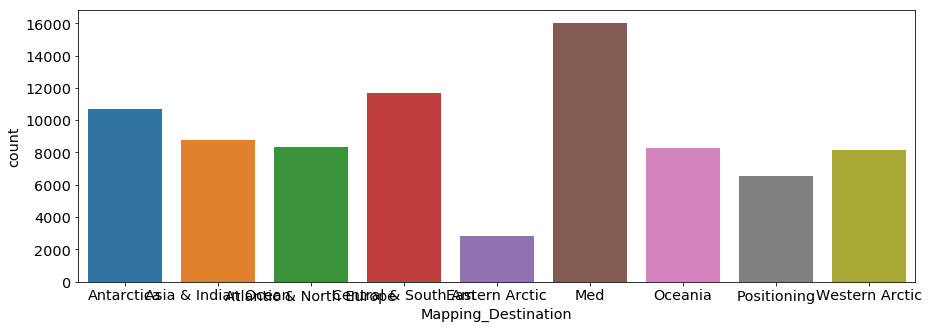

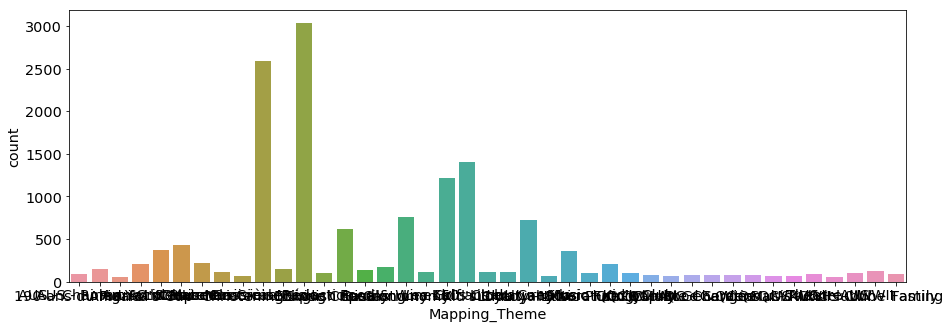

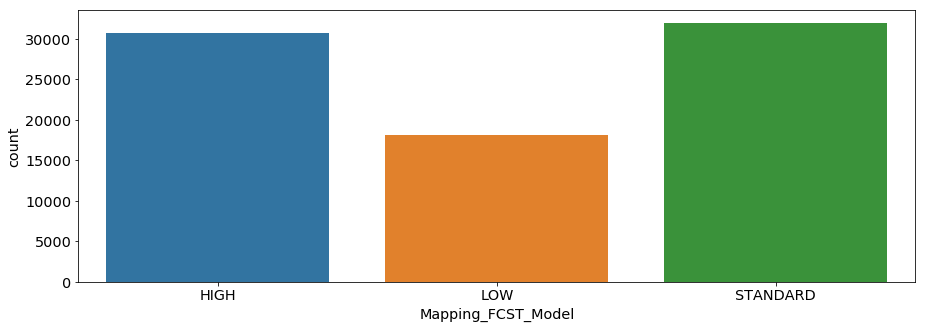

In [94]:
import seaborn as sns
for cat_var in categorical_variables:
    sns.countplot(df[cat_var])                             
    plt.show()